In [4]:
import sys
sys.path.append('/home/robbie/Dropbox/SP_W99_Drifters/')
# import ERA5_utils
%config Completer.use_jedi = False
import itertools
from scipy import spatial
import numpy.ma as ma
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np
import datetime, pickle
import matplotlib.pyplot as plt
import time
import tqdm
import cartopy.crs as ccrs
import cartopy
import dateutil.parser
import os
import ll_xy
import re
import collections
from netCDF4 import Dataset
import mask


dir_to_save = '/home/robbie/Dropbox/Apps/Overleaf/SnowModel-LG_Paper_v2'

In [5]:
years_dict = {"03":[54,55],
              "04":[54,55,56],
              "05":[55,56],
              "06":[56,57,58,59],
              "07":[57,58,59],
              "08":[61,62],
              "09":[60,61],
              "10":[61,62,63,64],
              "11":[62,63],
              "12":[63,64,65],
              "13":[64,65,66,67],
              "14":[65,66],
              "15":[66,67,68],
              "16":[68,69,70,71,72],
              "17":[68,69],
              "18":[68,69,70,71],
              "19":[69,70,71,72,73],
              "20":[70,71,72],
              "21":[72,73,74],
              "22":[73,74,75,76,77,78,79,80,81,82],
              "23":[76,77,78],
              "24":[78,79,80],
              "25":[81,82,83,84],
              "26":[83,84],
              "27":[84,85,86,87],
              "28":[86,87,88],
              "29":[87,88],
              "30":[87,88,89,90,91],
              "31":[89,90,91]}

r_codes  = {"Lakes":0,
        "Oceans":1,
        "Okhotsk":2,
        "Bering":3,
        "Hudson":4,
        "St Lawrence":5,
        "Baffin":6,
        "Greenland":7,
        "Barents":8,
        "Kara":9,
        "Laptev":10,
        "East Siberian":11,
        "Chukchi":12,
        "Beaufort":13,
        "Canadian Archipelago":14,
        "Central Arctic":15,
        "Land":20,
        "Coast":21}


Regions = {"Kara":('Oranges',(0.705,0.44)),
            "Laptev":('Blues',(0.65,0.63)),
            "East Siberian":('Greens',(0.58,0.78)),
            "Chukchi":('Reds',(0.353,0.82)),
            "Beaufort":('pink',(0.23,0.72)),
            "Central Arctic":('Purples',(0.385,0.58)),
            "Barents":('Set2',(0.63,0.25))}

month_nums = {'jan':1,
              'feb':2,
              'fab':2,
              'mch':3,
              'mar':3,
              'apr':4,
              'may':5,
              'jun':6,
              'jul':7,
              'aug':8,
              'spt':9,
              'sep':9,
              'oct':10,
              'nov':11,
              'dec':12}

precip_dir = '/home/robbie/Dropbox/SP_W99_Drifters/Data/W99_clean/PRECIP/'
met_dir = '/home/robbie/Dropbox/Data/W99_raw/MET/'

my_mask = mask.get('mask')
lon = mask.get('lon')
lat = mask.get('lat')


mask_x, mask_y = ll_xy.lonlat_to_xy(np.array(lon),
                                         np.array(lat),
                                         hemisphere='n')    
    

mask_grid = list(zip(mask_x.ravel(),mask_y.ravel()))

tree = spatial.KDTree(mask_grid)


In [23]:
regs_of_interest = ['Barents', 'Kara', 'Laptev', 'East Siberian', 'Chukchi', 'Beaufort', 'Central Arctic']
nice_regs = ['Barents', 'Kara', 'Laptev', 'East\nSiberian', 'Chukchi', 'Beaufort', 'Central\nArctic']

winter_months = [10,11,12,1,2,3,4]
winter_mon_names = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr']

In [24]:
met_fields = ['Station ID',
                  "Year",
                  "Month",
                  "Day",
                  "Time",
                  "Latitude",
                  "Longitude",
                  "Air temperature",
                  "Relative humidity",
                  "Sea level pressure",
                  "Wind direction",
                  "Wind speed",
                  "Total cloudiness",
                  "Low cloudiness",
                  "Surface temperature"]

met_dict = {}
reg_dict = {}

for month, region in itertools.product(winter_months, regs_of_interest):
    reg_dict[(region,month)] = 0


for station_num in tqdm.tqdm(years_dict.keys()):

    met_data = pd.read_csv(f'{met_dir}METNP_{station_num}.DAT',
                           delim_whitespace=True,
                           index_col=False,
                           names=met_fields)

    met_data.replace([-9.9,-9,9999], np.nan, inplace=True)

    met_data['Year'] = met_data['Year'] + 1900

    met_data['date'] = pd.to_datetime(met_data[['Year','Month','Day']])

    fictional_dates = [ind for ind, date in enumerate( met_data['date']) if pd.isnull(date)]

    met_data.drop(fictional_dates,inplace=True)

    hours_list = [datetime.timedelta(hours=x) for x in met_data['Time']]

    met_data['UTC'] = [(x+y)-datetime.timedelta(hours=3) for x, y in zip(met_data['date'],hours_list)]

    met_data.drop(columns=['date','Month','Year','Day','Time','Station ID'],inplace=True)

    met_data.set_index(['UTC'],inplace=True,drop=True)
    
    
    met_data['x'], met_data['y'] = ll_xy.lonlat_to_xy(np.array(met_data['Longitude']),
                                              np.array(met_data['Latitude']),
                                              hemisphere='n')    
    
    met_data.dropna(how='any',subset=['x','y'], inplace=True)
    
    distance, index = tree.query(list(zip(met_data['x'], met_data['y'])),distance_upper_bound=1e9)
        
    met_data['i_ind'], met_data['j_ind'] = np.unravel_index(index, (361,361))
        
    met_data['region'] = [my_mask[i,j] for i,j in zip(met_data['i_ind'], met_data['j_ind'])]
    
    for month, region in itertools.product(winter_months, regs_of_interest):
        
        df_mr = met_data[(met_data.index.month == month) & (met_data['region'] == r_codes[region])]
        
        if df_mr.shape[0]:
            reg_dict[(region,month)] +=1
    
    met_dict[station_num] = met_data.resample('1D').mean()
    
#     break
    
print('Done!')

100%|███████████████████████████████████████████| 29/29 [00:05<00:00,  5.24it/s]

Done!


['Barents', 'Kara', 'Laptev', 'East Siberian', 'Chukchi', 'Beaufort', 'Central Arctic']
[10, 11, 12, 1, 2, 3, 4]


/tmp/ipykernel_26194/3647113741.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([""]+nice_regs,fontsize='large')
/tmp/ipykernel_26194/3647113741.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels([""]+winter_mon_names,fontsize='large')


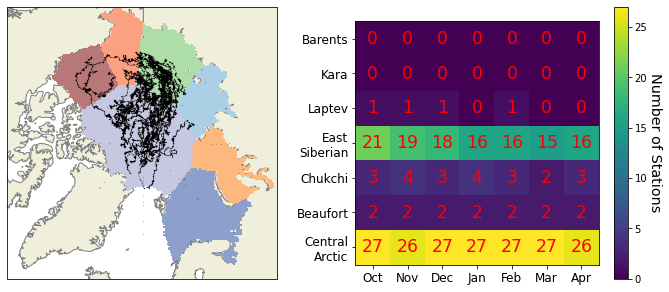

In [29]:
hmap = np.zeros((len(regs_of_interest), len(winter_months)))

for rcount, region in  enumerate(regs_of_interest):
    for mcount, month in enumerate(winter_months):
        
        hmap[rcount,mcount] = reg_dict[(region,month)]
        
my_mask = mask.get('mask')
lon = mask.get('lon')
lat = mask.get('lat')
        
print(regs_of_interest)
print(winter_months)

fig = plt.figure(figsize=(12,5))

# ax = plt.axes(projection=ccrs.NorthPolarStereo())
ax = fig.add_subplot(1,2,1,projection=ccrs.NorthPolarStereo())

ax.add_feature(cartopy.feature.LAND.with_scale('50m'), edgecolor='gray')

ax.set_extent([-180, 180, 66, 72], ccrs.PlateCarree())

for region in Regions.keys():
    
    region_mask = np.ones((361,361))
    region_mask = ma.masked_where(my_mask != r_codes[region], region_mask)
    region_mask = np.ma.filled(region_mask.astype(float), np.nan)

    ax.pcolormesh(lon, lat, region_mask[:-1,:-1], cmap=Regions[region][0], vmin=0, vmax = 3, transform=ccrs.PlateCarree())


for key in met_dict.keys():
    
    df = met_dict[key]
    
    lon = df['Longitude']
    lat = df['Latitude']


    ax.scatter(np.array(lon), np.array(lat),
                 transform=ccrs.PlateCarree(),s=0.01,alpha=1,color='k')


ax2 = fig.add_subplot(1,2,2)


###################################################################

# Define what the colours should be and where the annotations should go



###################################################################

# Make the plot


hplot = ax2.imshow(hmap)
ax2.set_yticklabels([""]+nice_regs,fontsize='large')
ax2.set_xticklabels([""]+winter_mon_names,fontsize='large')

for rcount, region in  enumerate(regs_of_interest):
    for mcount, month in enumerate(winter_months):
        ax2.annotate(f'{reg_dict[(region,month)]}', xy=(mcount,rcount), color='red',
                    xycoords='data', ha='center', va='center',fontsize='xx-large')
        
cbar = fig.colorbar(hplot)
cbar.set_label('Number of Stations', rotation=270, labelpad=15, fontsize='x-large')

# plt.savefig(f"{dir_to_save}/Sup_Figs/drifters.jpg",dpi=400, bbox_inches='tight')